In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, auc, f1_score, explained_variance_score


import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../src/visualization/')
import visualize as vis

In [29]:
df = pd.read_csv('../data/processed/CriticalPath_Data_EM_Confidential_lessNoise.csv').drop(columns=['Unnamed: 0'])

## XGBoost Model to see which features most impact enrollment.

### Starting Parameters

## Split into training and test data, and fit a regression model.

In [30]:
X = df.drop(columns=['Enrolled','Admission_status',
                     'Unique_student_ID']).select_dtypes([float,bool,int]).fillna(-999)

Y = df['Enrolled'].fillna(-999)


X_train, X_test, y_train, y_test = train_test_split(X, Y)

best_params = {'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 11,
 'missing': -999,
 'n_estimators': 500,
 'nthread': 4,
 'seed': 42,
 'silent': 1,
 'subsample': 0.8}  # found from GridSearchCV (013-st-model_paramters.ipynb)

In [31]:
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print( "R2 Score: ", r2_score(y_test, y_pred) )
print(explained_variance_score(y_pred,y_test))

R2 Score:  0.9872039311919478
0.9870716333389282


## Plot feature importance

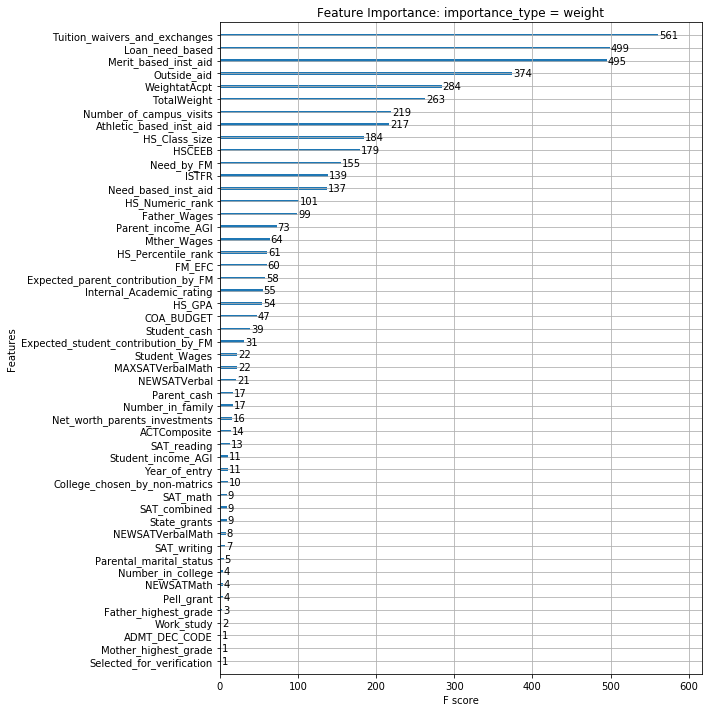

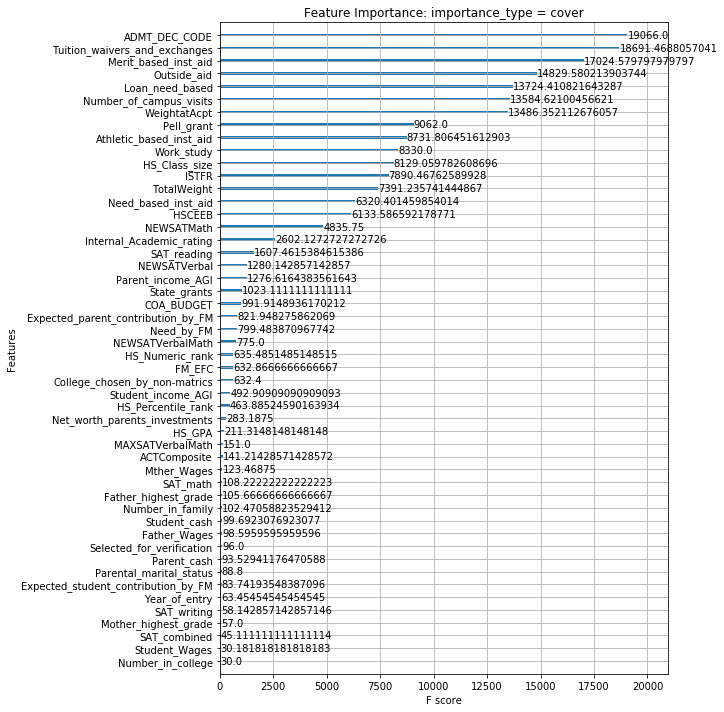

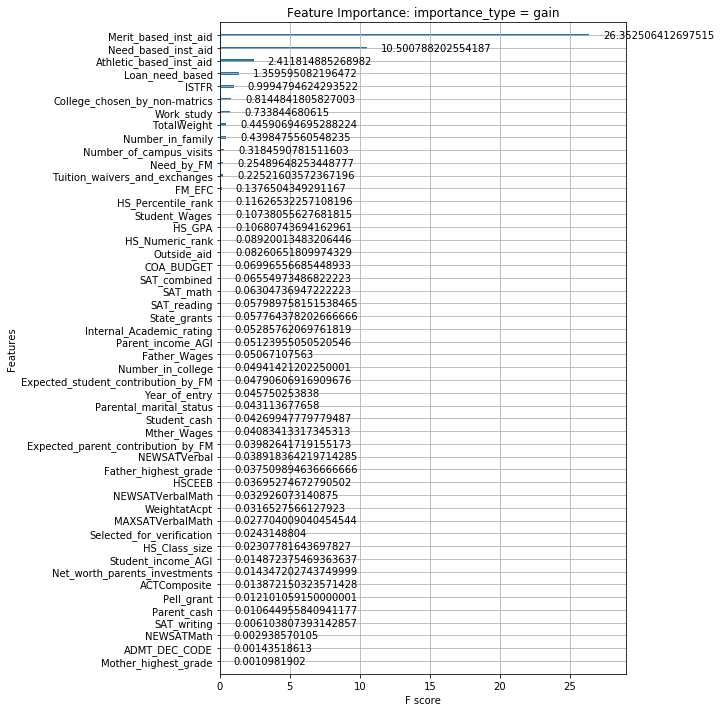

In [32]:
for importance_type in ['weight','cover','gain']:
    vis.my_plot_importance(model,figsize=(10,10),importance_type=importance_type);
    plt.tight_layout()
    plt.title('Feature Importance: importance_type = %s' %importance_type)
    plt.savefig("../reports/figures/feature_importance/feature_importance_%s.png" %importance_type)

## Plot shapley values.
* *An intuitive way to understand the Shapley value is the following illustration: The feature values enter a room in random order. All feature values in the room participate in the game (= contribute to the prediction). The Shapley value of a feature value is the average change in the prediction that the coalition already in the room receives when the feature value joins them.*
 
* *The interpretation of the Shapley value is: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.*





[cristophm.gihub.io](https://christophm.github.io/interpretable-ml-book/shapley.html):

In [33]:
shap.initjs()
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [34]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue (these force plots are introduced in our Nature BME paper).

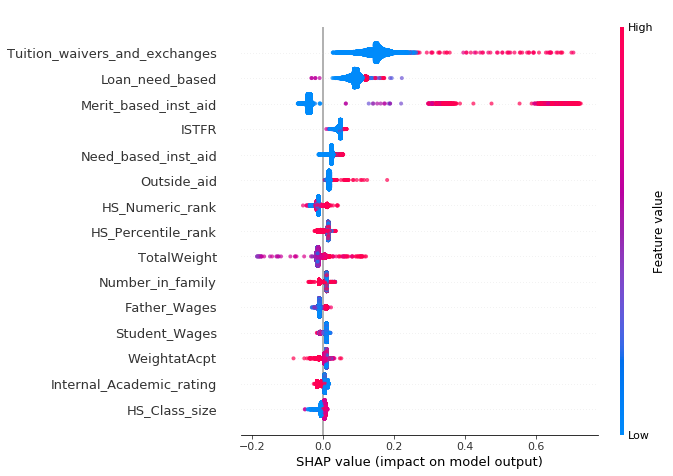

In [35]:
sum_plot = shap.summary_plot(shap_values, X, max_display=15, show=True, alpha=0.7,
                  plot_type='dot')

# plt.tight_layout()
# plt.savefig("../reports/figures/feature_importance/shapley_summary.png")

## Plot this as a bar chart.

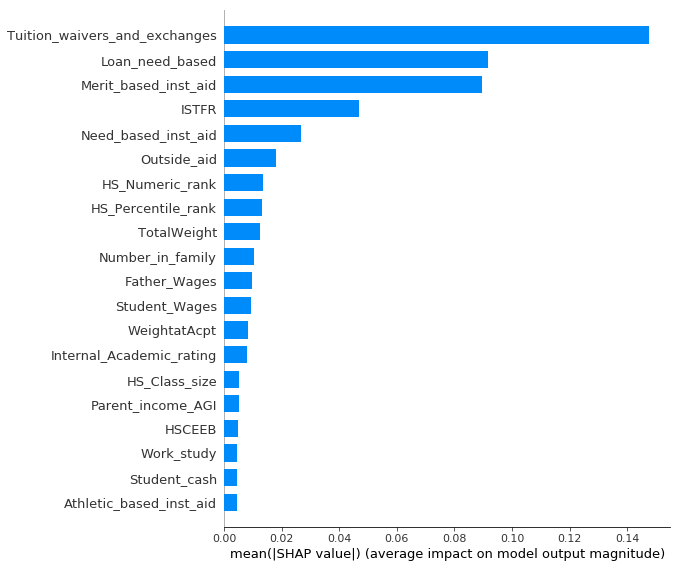

In [36]:
shap.summary_plot(shap_values, X, max_display=20, show=True,
                  plot_type='bar')
# plt.tight_layout()
# plt.savefig("../reports/figures/feature_importance/shapley_summary_bar.png")

### The top 5 columns have a **huge** impact on the model in comparison with everything else..... is there a reason for this??

In [37]:
for col in ['Tuition_waivers_and_exchanges','Merit_based_inst_aid','Loan_need_based','Outside_aid','TotalWeight']:
    print(col, "has %d NaN values." % df[col].isna().sum()  ) 

Tuition_waivers_and_exchanges has 31875 NaN values.
Merit_based_inst_aid has 29163 NaN values.
Loan_need_based has 30214 NaN values.
Outside_aid has 31480 NaN values.
TotalWeight has 0 NaN values.


So what is `df['TotalWeight']`???

## Individual features.

#### X axis is feature value
#### Y axis is the associated shapley value (ouput impact)

#### Red/Blue is a value of potential interaction effect

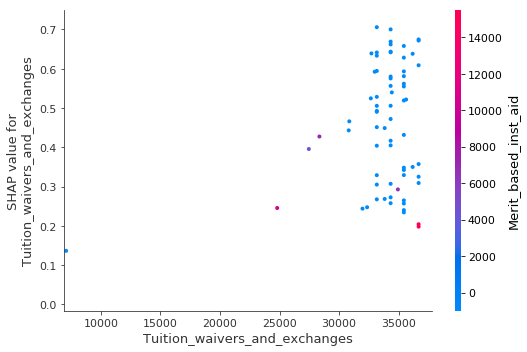

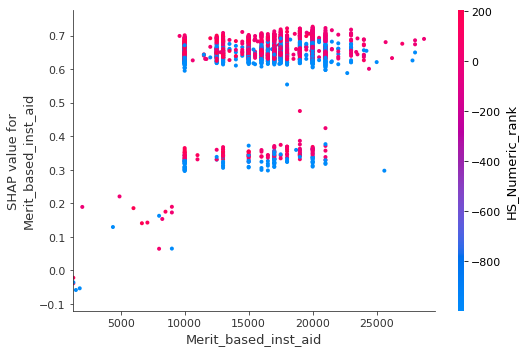

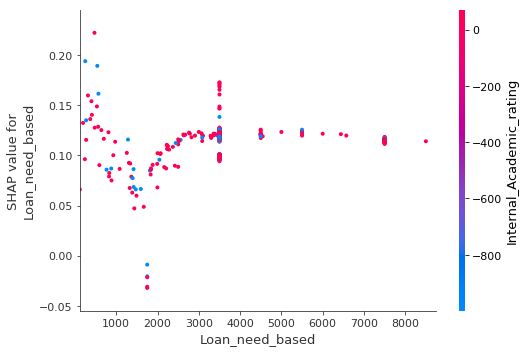

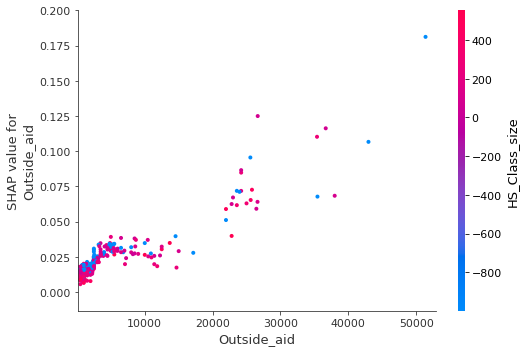

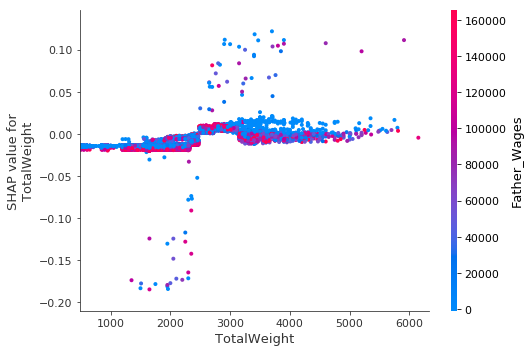

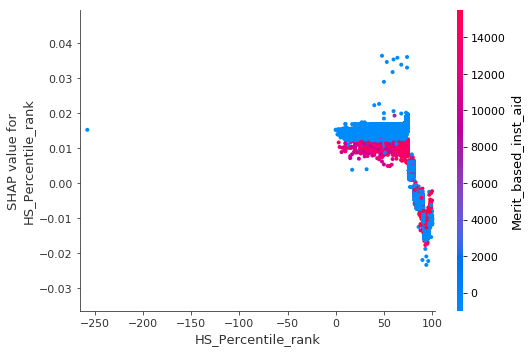

In [38]:
for feature in [
    'Tuition_waivers_and_exchanges','Merit_based_inst_aid','Loan_need_based','Outside_aid','TotalWeight','HS_Percentile_rank'
]:
#     print(feature)
    plt.figure()
    shap.dependence_plot(feature, shap_values, X,show=False)
    plt.tight_layout()
    plt.xlim(np.nanmin(df[feature])-0.03*abs(np.nanmin(df[feature])),1.03*np.nanmax(df[feature]))
#     plt.savefig("../reports/figures/feature_importance/individual_feature-%s.png" % feature)    

## Boosted decision tree

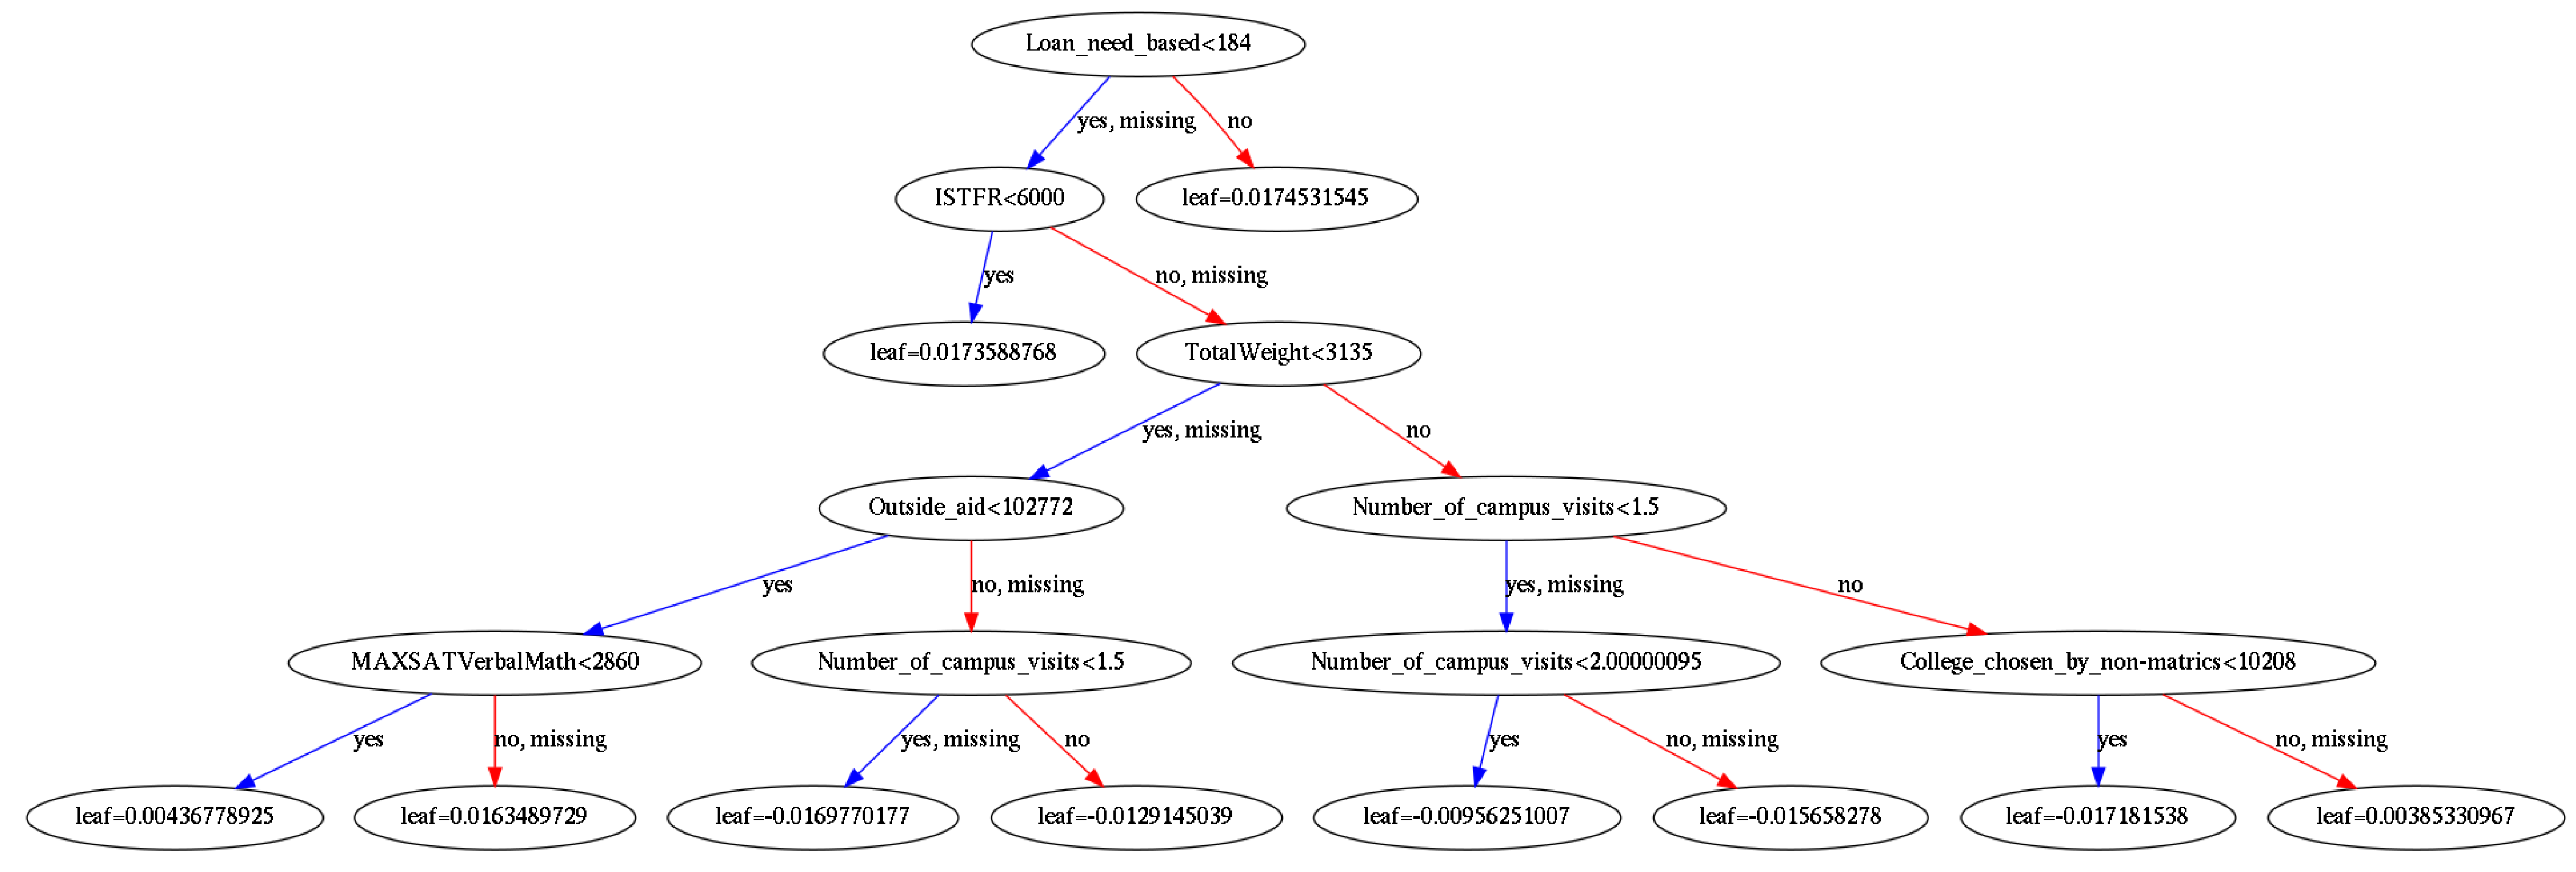

In [39]:
xgb.plot_tree(model, num_trees=7)
fig = plt.gcf()
fig.set_size_inches(75, 50)
# fig.savefig('../reports/figures/tree.png')